<span style="color:#327887">

Test my text


</span>



### e-mail from Jiahang

Hi Rafael

Congrats on the good progress so far!

Please find the take-home kit in [this link](https://drive.google.com/file/d/1Q9s9q07gmwopR5qtsk7O8JT40ZcNCDJD/view). We'd like you to **complete the notebook within it** and send back a copy of the notebook **with run output and documentation**. It would be great if you can add **your name to the filename** as well.

As we appreciate your time taking this test, we have designed it with the hope to only take you about 3 hours. That being said, there is no time constraint here so it's your choice of when
and how much time you need. We’d love to hear your feedback if it actually costs you longer than we intended, or if it's not enough fun for you. 
 

Cheers,

Jiahang

-----

# Instructions

Thanks for taking your time to complete this take-home task. 

This is where you can show off all your decision science skills through a hands-on project. Together with the dataset, this notebook presents a series of typical problems we face in our job. We expect you to complete the notebook with insightful analysis, elegant code and clear documentation of your findings (perfectly OK to embed within this notebook, just make sure using a distinct color). Please also feel free to keep in the final notebook any code+result where you believe there is value, even if it's not directly addressing the questions below.

We have designed this test with the hope to only take you about 3 hours. We know it’s still quite a commitment of your time and we really appreciate it. That being said, this test is not timed so feel free to spend more time if needed. We’d love to hear your feedback if it actually cost you longer than we intended. It is easy for us to underestimate the required efforts when we know the answers already! Please also tell us if you haven’t had enough fun 😂


## Hints

*   We encourage our decision scientists to use open-source solutions as much as possible instead of re-inventing the wheels. So please feel free to Google for a solution before writing any complicated code. 
*   If you are running short of time but have lots of extra great ideas you'd like to explore, feel free to write down your thoughts in words or pseudo-code instead of code.

## Context

The project we have here is to validate and monitor two credit risk decision models for personal loan underwriting decisions. The information we collected at the underwriting stage of successful applications (i.e. approved and disbursed) were used as the input features of these two models. The two models were trained to predict whether the customers will repay all scheduled payment in the following X months. 

We can split our data into the following three parts:
1.   the **development sample**: all loans applications before 1st August 2019
2.   the **out-of-time monitoring sample**: all loans applications between 1st August 2019 and 1st Jan 2020
3.   the **post-deployment monitoring sample**: all loans applications since 1st Jan 2020


# Part 1. Data processing

Here we have two synthetic datasets of loan customers. 


The file ***monthly_outcome.csv*** contains the repayment *status* at each scheduled payment *date*. The numeric values in column *status* represent how many monthly repayments they were missing. i.e. 0 means they were up to date without any arrear, 3 means they were at that time missing three repayments. Once a customer reaches a status of missing 4 payments, we marked them as 'D' which means it has defaulted. For simplicity let's assume it as a terminal status and all the following records will be 'D' as well. 

The file ***application.csv*** contains
1.   a few variables about the customer we acquired during their loan applications
2.   a binary variable (*is_bad_12m*) of their repayment performance 12 months after disbursal 

**Target definition**: the binary target variable *is_bad_12m* was created by looking at the arrear status of the customers across the 12 dates where the repayment was scheduled. If at any point they had 3 or more repayments missing, this variable would be set to 1, otherwise 0. 

Each loan is represented by an *unique_id* in these two files.



In [55]:
# Imports and general definitions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz

COLORS = ["#327887", "#8abb9c", "#dfc586", "#e83860"]

## Task 1.1: data cleaning

Although we are proud of our data infrastructure, it's always a good practice to sense check and clean up a bit. We have left you a few surprises here. Have fun!



<span style="color:#327887">

Here I just have replaced the large negative numbers by NaN values and established the most convenient data type for the variables.

I will live the subjects with NaN values and evaluate the best strategy for dealing with them based on each particular task.

To better understand the data I am generating two visualization reports with *sweetviz.*

The reports are saved at [data/reports/monthly_outcome_view.html](data/reports/monthly_outcome_view.html) and [data/reports/application_view.html](data/reports/application_view.html).

It is possible to visualize the reports inside the jupyter notebook using monthly_outcome_view.show_notebook() or application_view.show_notebook(), but I found more convenient to have full view of the report on another tab.

I add a plot of the loan distribution over time just to check any unusual behavior.
</span>

In [ ]:
monthly_outcome = pd.read_csv("data/raw/monthly_outcome.csv", index_col=0, na_values=[-999997, -999999.0])
monthly_outcome.loc[:, ("date")] = pd.to_datetime(monthly_outcome.date, format='%Y-%m-%d')
monthly_outcome.loc[:, ("defaulted")] = monthly_outcome.status == "D"
monthly_outcome.loc[:, ("status")] = monthly_outcome.status.replace("D", 4).astype(float).astype(int)
monthly_outcome.dtypes.to_csv("data/clean/monthly_outcome_dtypes.csv")
monthly_outcome.to_csv("data/clean/monthly_outcome.csv")
MONTHLY_OUTCOME_DTYPES = pd.read_csv("data/clean/monthly_outcome_dtypes.csv", index_col=0)["0"].to_dict()
monthly_outcome = pd.read_csv("data/clean/monthly_outcome.csv", index_col=0).astype(MONTHLY_OUTCOME_DTYPES)

monthly_outcome_view = sweetviz.analyze(monthly_outcome)
monthly_outcome_view.show_html(filepath="data/reports/monthly_outcome_view.html")

In [ ]:
DTYPES = {
    'is_bad_12m': int,
    'loan_term': int,
    'age_oldest_account': int,
    'total_value_of_mortgage': int,
    'current_utilisation': int,
    'months_since_2_payments_missed': int,
    'number_of_credit_searches_last_3_months': int,
    'origination_date': np.datetime64,
}
application = pd.read_csv("data/raw/application.csv", index_col=0, na_values=[-999997, -999999.0])
application = application.fillna(-999999).astype(DTYPES).replace(-999999, None)
application.dtypes.to_csv("data/clean/application_dtypes.csv")
application.to_csv("data/clean/application.csv")
APPLICATION_DTYPES = pd.read_csv("data/clean/application_dtypes.csv", index_col=0)["0"].to_dict()
application = pd.read_csv("data/clean/application.csv", index_col=0).astype(APPLICATION_DTYPES)
application_view = sweetviz.analyze(application)
application_view.show_html(filepath="data/reports/application_view.html")

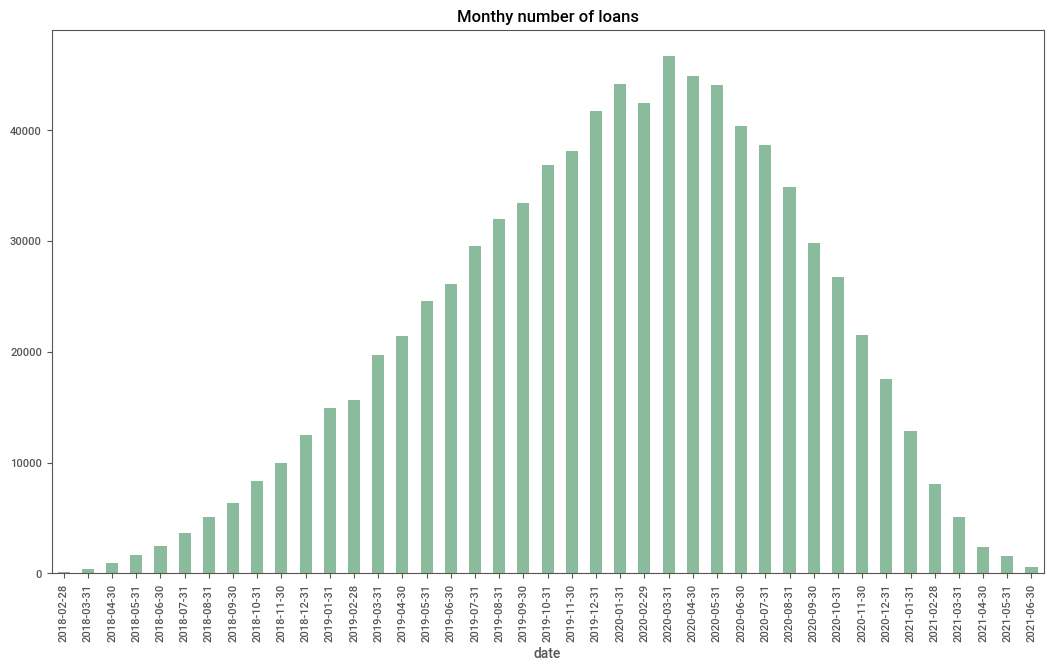

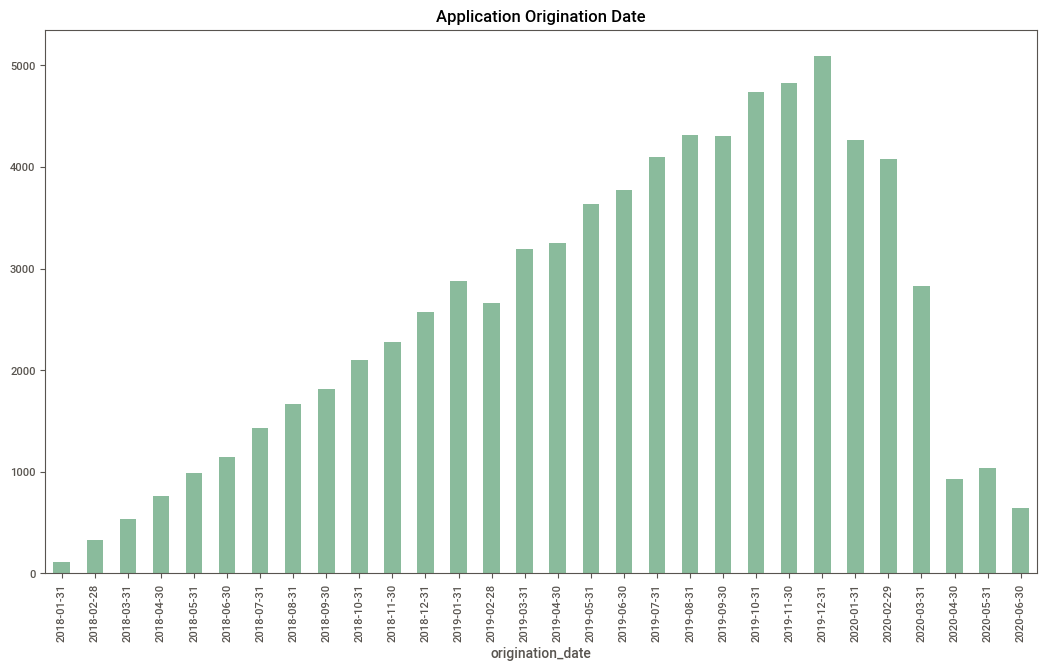

In [58]:
fig, ax = plt.subplots(figsize=(16*0.8, 9*0.8))
monthly_outcome.resample(rule='M', on='date')["status"].count().plot.bar(ax=ax, color="#8abb9c")
ax.set_xticklabels([txt.get_text().split(" ")[0] for txt in ax.get_xticklabels()])
plt.title("Monthy number of loans")
plt.savefig("data/reports/monthy_number_of_loans.png")
plt.show()

fig, ax = plt.subplots(figsize=(16*0.8, 9*0.8))
application.resample(rule='M', on='origination_date')["origination_date"].count().plot.bar(ax=ax, color="#8abb9c")
ax.set_xticklabels([txt.get_text().split(" ")[0] for txt in ax.get_xticklabels()])
plt.savefig("data/reports/application_origination_date.png")
plt.title("Application Origination Date")
plt.show()

## Task 1.2: another target
In order to understand the performance of a model before it's too late, we also want to monitor the repayment behaviours after the first few repayments. 

Could you please create another "early-risk" target *is_bad_3m* which represents whether the customers ever had **2 or more** repayments in arrear at any point of their first three scheduled ones?



# Part 2. Model validation

In this part let's assume we are still at the model development stage and look at the development sample only (see definition at the start). We will skip the model training part here (which is too much fun to finish in 3 hours), and assume that we already trained two candidate models. These are of course probabilistic classification model, which you can find their scores in ***application.csv*** as columns *model_1* and *model_2*. 

We need to compare their performance and decide which one to use in production. The winner model, once deployed, will be used for decisions of

*   Loan approval: the score must be above certain threshold (which can be adjusted during operation) for the application to be approved. 
*   Loss estimate: for each approved loan, we use the model output to predict the probability of default. 
*   Pricing: based on the loss estimate, we decide the interest rate to be charged in order to cover potential losses. 









## Task 2.1: classification power

A common metric used in the credit risk modelling world is the Gini coefficient, which can be linearly mapped to ROCAUC if that's a term you are more familiar with. Could you please compare the Gini's between the two models as a first step? 




An extended question: assuming that classification power is all we care about, what are the other reasons to not pick the model with highest Gini? It's enough to just write down your thoughts. 


## Task 2.2: classification power in segments

As the population of future business might have different distributions from the development sample, we would ideally want the chosen model to be performant in all segments. For simplicity let's stick with univariate segments only.

Could you please compare the Gini's between the two models in the segments of all the variables? Feel free to define the segments as you see appropriate. 



## Task 2.3: accuracy 
As we want to use our model for loss estimates and pricing of each customer, could you please check whether the scores (as probabilistic predictions) are accurate with respect to the actual "bad rates" (i.e. the fraction of *is_bad_12m*=1 among customers of similar scores)

## Task 2.4: calibration

We also want to monitor the early risk indicator *is_bad_3m* in case something really bad happens (e.g. a pandemic). For that we need to calibrate our scores to the probability of such short-term outcome. Could you please create the calibrated scores for the two models and validate them? (Hint: if this is not a topic you are familiar with, scikit-learn has some handy utilities)

# Part 3. Model monitoring

The training and validation of a model is just part of the story. A large part of our work is to understand how our models perform in real life deicisioning and how we adapt to the changing market. In this part we will look into the monitoring sample (see definition at the start).

Now let's assume that we have choosen *model_1* and deployed it to production since 1st Jan 2020. On that day, our decision engine started to use that model, and since then only approved applications with *model_1*<0.05. 


## Task 3.1: model performance

How did the model perform in this monitoring sample, before & after its deployment into production? How does that compare to the expectation from the development sample? 

## Task 3.2: why the changes?

If you observe a difference, what do you think can be the reason(s)? How are you going to verify your hypothesis?

## Task 3.3: new variable

You might have noticed that a new variable ***stress_score*** has become available since late 2019. Can you figure out whether there is additional classification power from this variable over our models? 

If so, how would you incorporate it into our decision model?
